## AUTHOR: ABEEB ADEKUNLE GARBA

### External Grid + Photovoltaic System (PV) + Battery (BAT) components to cater for a Power Demand (DEM),


In [1]:
import comando
from comando.core import Component, System
import pandas as pd
from comando.interfaces.pyomo import to_pyomo
from datetime import datetime

### External Grid class
Comando offers the already pre-defined class 'Component'

The component ExternalGrid contains a variable for the power usage, a price for this quantity, the overall costs and an output as a connector which is the power usage

In [2]:
class ExternalGrid(Component):
    """A source for an arbitrary commodity."""
    def __init__(self, label, max_capacity1):
        """Initialize the Source.

        Arguments
        ---------
        - label : str
            Unique string that serves as an identifier of this Source.
        - price : numeric data
            Price per unit of provided commodity, can be a scalar or a
            pandas Series.
        """
        super().__init__(label)
        
        buy_price = self.make_parameter('buy_price', 0.3) #  $KW
        use_grid = self.make_operational_variable('use_grid', bounds=(0, 5000))
        self.add_expression('buy_cost', 0.3*use_grid)
        self.add_output('OUT', use_grid)
        

        selling_price = self.make_parameter('selling_price', 0.05) # $/KW
        feeding = self.make_operational_variable('feeding', bounds=(0, 4000))
        self.add_expression('sel_cost', 0.05*feeding)
        self.add_input('IN', feeding)
        
        
        self.add_expression('variable_costs', (use_grid*buy_price)-(feeding*selling_price))

### Demand class
The component 'Demand' contains the parameter for the power demand and a connector for this power demand

In [3]:
class Demand(Component):
    """A demand requiring a known amount of an arbitrary commodity"""

    def __init__(self, label, data=0):
        """Initialize the Demand.

        Arguments
        ---------
        - label : str
            Unique string that serves as an identifier of this Demand.
        - data : numeric data
            Amount of consumed commodity, can be a scalar or a pandas
            Series.
        """
        super().__init__(label)
        demand = self.make_parameter('demand', data)
        self.add_input('IN', demand)

### Component PV array
* Size as design variable
* Costs per installed kW
* Power factor based on solar irradiation
* Actual power output, including connector
* Investment costs and fixed costs (based on lifetime and interest rate)

In [4]:
class Photovoltaic(Component):
    """
    Model of a PV park
    """
    def __init__(self, label, max_capacity):
        """
        Initialization of the maximal capacity
        :param label: Name of the PV park
        :param max_land_use: Maximal allowed land use
        """
        super().__init__(label)

        self.invest_cost = 690  # [€/kW]
        psi = 0.017  # o&m costs

        size = self.make_design_variable("size", bounds=(0, max_capacity))  # [kWp]

        power_factor = self.make_parameter("power_factor")  # [kW/kWp]
        el_out = self.make_operational_variable("el_out")
        self.add_le_constraint(el_out, size * power_factor)

        n = 27  # lifetime
        i = 0.06
        af = ((1 + i) ** n * i) / ((1 + i) ** n - 1)  # annuity factor
        invest_cost = size * self.invest_cost
        self.add_expression("investment_costs", invest_cost * af)
        self.add_expression("fixed_costs", invest_cost * psi)

        self.add_output("OUT", el_out)

## Battery class
Component with a state of charge via declare_state and comando.cyclic

In [5]:
class SimpleBattery(Component):
    """
    Simple model of a battery
    """
    def __init__(self, label, max_capacity3, eff=0.98, invest_cost=800):
        """
        Initialization of the battery model
        :param max_capacity: Maximal allowed capacity of the battery
        """
        super().__init__(label=label)
        efficiency = eff
        self.invest_cost = invest_cost  # [€/kWh] 
        psi = 0.022  # o&m costs
        
        size = self.make_design_variable("size", bounds=(0, max_capacity3))
        electricity_input = self.make_operational_variable("electricity_input")
        electricity_output = self.make_operational_variable("electricity_output")
        SOC = self.make_operational_variable('SOC', bounds=(0, max_capacity3))
        self.add_le_constraint(SOC, size, name='SOC_max')
        state_change = electricity_input * eff - electricity_output / eff
        self.declare_state(SOC, state_change, comando.cyclic, der_bounds=(-max_capacity3, max_capacity3))
       
        n = 12  # lifetime
        i = 0.06
        af = ((1 + i) ** n * i) / ((1 + i) ** n - 1)  # annuity factor
        invest_cost = size * self.invest_cost
        self.add_expression("investment_costs", invest_cost * af)
        self.add_expression("fixed_costs", invest_cost *psi)
        self.add_expression('Dissip_losses', 0.002 * SOC)
        self.add_expression('soc', SOC/size)

        "Add inputs and outputs"
        self.add_input("EL_IN", electricity_input)
        self.add_output("EL_OUT", electricity_output)

### Initialization of the components and creation of the energy system

In [6]:
demand = Demand('demand')
grid = ExternalGrid('grid', max_capacity1=5000) #5000kW
pv = Photovoltaic('pv', max_capacity=7000) # 7000kW
batt = SimpleBattery('batt', max_capacity3=3000) # 3000kW

ES = System('energy_system')

### Adding components to energy system

In [7]:
comp = [demand, grid, pv, batt]
for c in comp:
    ES.add(c)
print(ES)

System('energy_system', components={Component('demand'), Component('grid'), Component('batt'), Component('pv')}, connections={})


### Setting the connections

In [8]:
ES.connect('Electricity_bus', [demand.IN, grid.OUT, grid.IN, pv.OUT, batt.EL_IN, batt.EL_OUT])
print(ES.connections)

{'Electricity_bus': {Connector(Component('pv'), 'OUT', -pv_el_out), Connector(Component('demand'), 'IN', demand_demand), Connector(Component('batt'), 'EL_IN', batt_electricity_input), Connector(Component('grid'), 'OUT', -grid_use_grid), Connector(Component('batt'), 'EL_OUT', -batt_electricity_output), Connector(Component('grid'), 'IN', grid_feeding)}}


### Data handling

In [9]:
# original data
pv_data = pd.read_csv("ninja_pv_10.5155_9.3215_Bauchi.csv",
    skiprows=[0, 1, 2],
    usecols=[0, 1, 2],
    parse_dates=['time', 'local_time'])
name = 'pv_power_factor'
pv_data = pv_data.rename(columns={"electricity": name})  
pv_data[name] = pv_data[name] 

pv_data['hour'] = pv_data.index % 24
pv_data['day'] = pv_data.index // 24  
daily_pv = pv_data[[name, 'day', 'hour']] \
    .set_index(['day', 'hour']).unstack()[name]  
daily_pv

hour  0   1   2   3   4     5     6     7     8     9   ...    14    15    16  \
day                                                     ...                     
0      0   0   0   0   0     0 0.182 0.433 0.607 0.721  ...  0.54 0.354 0.112   
1      0   0   0   0   0 0.001 0.179 0.434 0.615 0.713  ... 0.528 0.332 0.091   
2      0   0   0   0   0     0 0.142  0.38 0.565 0.688  ... 0.487 0.288 0.069   
3      0   0   0   0   0     0 0.089 0.266 0.451 0.621  ... 0.511 0.303 0.063   
4      0   0   0   0   0     0 0.146 0.304 0.391 0.467  ... 0.487 0.312 0.079   
..    ..  ..  ..  ..  ..   ...   ...   ...   ...   ...  ...   ...   ...   ...   
360    0   0   0   0   0     0 0.129 0.375 0.567 0.704  ... 0.512 0.316 0.087   
361    0   0   0   0   0     0 0.184 0.437 0.615 0.736  ... 0.555 0.367 0.113   
362    0   0   0   0   0 0.001 0.201 0.455 0.627 0.745  ... 0.562 0.374 0.125   
363    0   0   0   0   0     0 0.156 0.398 0.576 0.702  ... 0.557 0.375 0.128   
364    0   0   0   0   0 0.001 0.213 0.462 0.629  0.74  ... 0.568 0.381 0.127   

hour  17  18  19  20  21  22  23  
day                               
0      0   0   0   0   0   0   0  
1      0   0   0   0   0   0   0  
2      0   0   0   0   0   0   0  
3      0   0   0   0   0   0   0  
4      0   0   0   0   0   0   0  
..    ..  ..  ..  ..  ..  ..  ..  
360    0   0   0   0   0   0   0  
361    0   0   0   0   0   0   0  
362    0   0   0   0   0   0   0  
363    0   0   0   0   0   0   0  
364    0   0   0   0   0   0   0  

[365 rows x 24 columns]

## Clustering of PV Data

In [10]:
pv_max = daily_pv.max().max()
daily_pv_norm = daily_pv/pv_max
daily_pv_norm

hour  0   1   2   3   4        5      6      7      8      9   ...     14  \
day                                                            ...          
0      0   0   0   0   0        0 0.2247 0.5346 0.7494 0.8901  ... 0.6667   
1      0   0   0   0   0 0.001235  0.221 0.5358 0.7593 0.8802  ... 0.6519   
2      0   0   0   0   0        0 0.1753 0.4691 0.6975 0.8494  ... 0.6012   
3      0   0   0   0   0        0 0.1099 0.3284 0.5568 0.7667  ... 0.6309   
4      0   0   0   0   0        0 0.1802 0.3753 0.4827 0.5765  ... 0.6012   
..    ..  ..  ..  ..  ..      ...    ...    ...    ...    ...  ...    ...   
360    0   0   0   0   0        0 0.1593  0.463    0.7 0.8691  ... 0.6321   
361    0   0   0   0   0        0 0.2272 0.5395 0.7593 0.9086  ... 0.6852   
362    0   0   0   0   0 0.001235 0.2481 0.5617 0.7741 0.9198  ... 0.6938   
363    0   0   0   0   0        0 0.1926 0.4914 0.7111 0.8667  ... 0.6877   
364    0   0   0   0   0 0.001235  0.263 0.5704 0.7765 0.9136  ... 0.7012   

hour     15      16  17  18  19  20  21  22  23  
day                                              
0     0.437  0.1383   0   0   0   0   0   0   0  
1    0.4099  0.1123   0   0   0   0   0   0   0  
2    0.3556 0.08519   0   0   0   0   0   0   0  
3    0.3741 0.07778   0   0   0   0   0   0   0  
4    0.3852 0.09753   0   0   0   0   0   0   0  
..      ...     ...  ..  ..  ..  ..  ..  ..  ..  
360  0.3901  0.1074   0   0   0   0   0   0   0  
361  0.4531  0.1395   0   0   0   0   0   0   0  
362  0.4617  0.1543   0   0   0   0   0   0   0  
363   0.463   0.158   0   0   0   0   0   0   0  
364  0.4704  0.1568   0   0   0   0   0   0   0  

[365 rows x 24 columns]

In [11]:
from sklearn_extra.cluster import KMedoids
# n is the number of typical days we want the clustering algorithm to output
n = 8
clusters = KMedoids(n_clusters=n).fit(daily_pv_norm)
# Return the actual day of the clusters (typical days)
print(clusters.medoid_indices_)
# Returns the cluster (e.g.,typical day) for each day, means position in clusters.medoid_indices_ (example: 4 --> day 339)
print(clusters.labels_)  # 365 entries for each day 

[ 85 261 138 246 136  38 115  65]
[5 5 5 7 0 5 7 4 5 5 5 5 5 7 7 5 5 5 5 5 5 5 5 5 5 5 5 0 5 5 5 2 1 5 5 5 2
 5 5 5 7 7 7 5 5 2 7 7 7 7 7 0 0 1 6 1 3 1 1 4 5 5 7 5 7 7 0 7 0 5 1 7 1 6
 0 2 7 7 0 7 0 2 0 7 4 0 7 7 7 2 0 2 7 7 7 0 0 1 6 6 2 0 6 6 0 0 2 0 6 2 2
 6 6 6 4 6 0 0 2 2 6 3 6 2 3 2 2 6 3 6 6 3 3 2 6 3 4 2 2 3 3 2 2 2 6 3 6 3
 3 3 3 3 3 6 4 3 3 3 3 6 2 6 6 4 6 2 2 2 2 2 3 3 3 3 3 6 3 4 3 2 6 4 3 3 3
 3 4 6 3 3 6 3 3 2 6 6 6 2 3 3 4 3 4 6 3 3 6 6 2 3 6 6 3 3 6 3 4 6 3 2 3 4
 2 4 2 1 3 4 3 6 3 1 3 0 6 3 1 4 3 3 3 0 1 4 0 4 3 2 0 0 3 2 0 0 0 0 3 3 4
 7 0 1 4 1 0 0 6 3 4 4 7 2 4 4 3 4 4 3 3 3 2 1 3 6 4 2 7 6 0 1 3 0 0 0 0 0
 6 3 7 4 4 7 5 7 7 7 7 5 5 5 5 5 5 7 4 7 3 7 5 5 5 5 5 7 7 5 7 5 5 5 5 5 5
 5 5 5 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 7 5 5 5 5 5]


In [12]:
pv_clusters = pd.Series(clusters.labels_, daily_pv.index)
pv_clusters

day
0      5
1      5
2      5
3      7
4      0
      ..
360    5
361    5
362    5
363    5
364    5
Length: 365, dtype: int64

In [13]:
# generate scenarios with 8 typical days and corresponding data and sort data
pv_scenarios = daily_pv.iloc[clusters.medoid_indices_].sort_index()
pv_scenarios

hour  0   1   2   3   4     5     6     7     8     9   ...    14    15    16  \
day                                                     ...                     
38     0   0   0   0   0 0.003 0.176  0.41 0.587 0.701  ... 0.534 0.343 0.108   
65     0   0   0   0   0 0.005 0.132 0.324 0.489   0.6  ... 0.432 0.256 0.078   
85     0   0   0   0   0 0.008 0.123 0.277 0.423 0.544  ... 0.402 0.241 0.079   
115    0   0   0   0   0 0.011 0.107  0.24 0.374 0.481  ... 0.262 0.142 0.046   
136    0   0   0   0   0 0.006 0.067 0.187 0.317 0.445  ... 0.327 0.191 0.074   
138    0   0   0   0   0 0.016 0.113 0.248  0.37 0.475  ... 0.339 0.209 0.067   
246    0   0   0   0   0 0.008 0.099 0.228  0.33 0.383  ... 0.218  0.13 0.043   
261    0   0   0   0   0 0.009 0.151 0.329 0.461 0.556  ...  0.26 0.135 0.056   

hour    17  18  19  20  21  22  23  
day                                 
38       0   0   0   0   0   0   0  
65       0   0   0   0   0   0   0  
85       0   0   0   0   0   0   0  
115      0   0   0   0   0   0   0  
136  0.004   0   0   0   0   0   0  
138  0.002   0   0   0   0   0   0  
246      0   0   0   0   0   0   0  
261      0   0   0   0   0   0   0  

[8 rows x 24 columns]

In [14]:
cluster_order = clusters.medoid_indices_.argsort()
# Getting the weights of each cluster by grouping them based on the clusters and getting the size
daily_pv.groupby(pv_clusters).size()

0    38
1    18
2    40
3    67
4    31
5    84
6    44
7    43
dtype: int64

In [15]:
# change order
weights = daily_pv.groupby(pv_clusters).size().div(365)[cluster_order]
weights.index = pv_scenarios.index
weights

day
38     0.2301
65     0.1178
85     0.1041
115    0.1205
136   0.08493
138    0.1096
246    0.1836
261   0.04932
dtype: float64

### Plotting of clustered data

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11968\3320438480.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("Dark2")    # This colormap only has 8 colors, therefore it can only plot up to 8 clusters


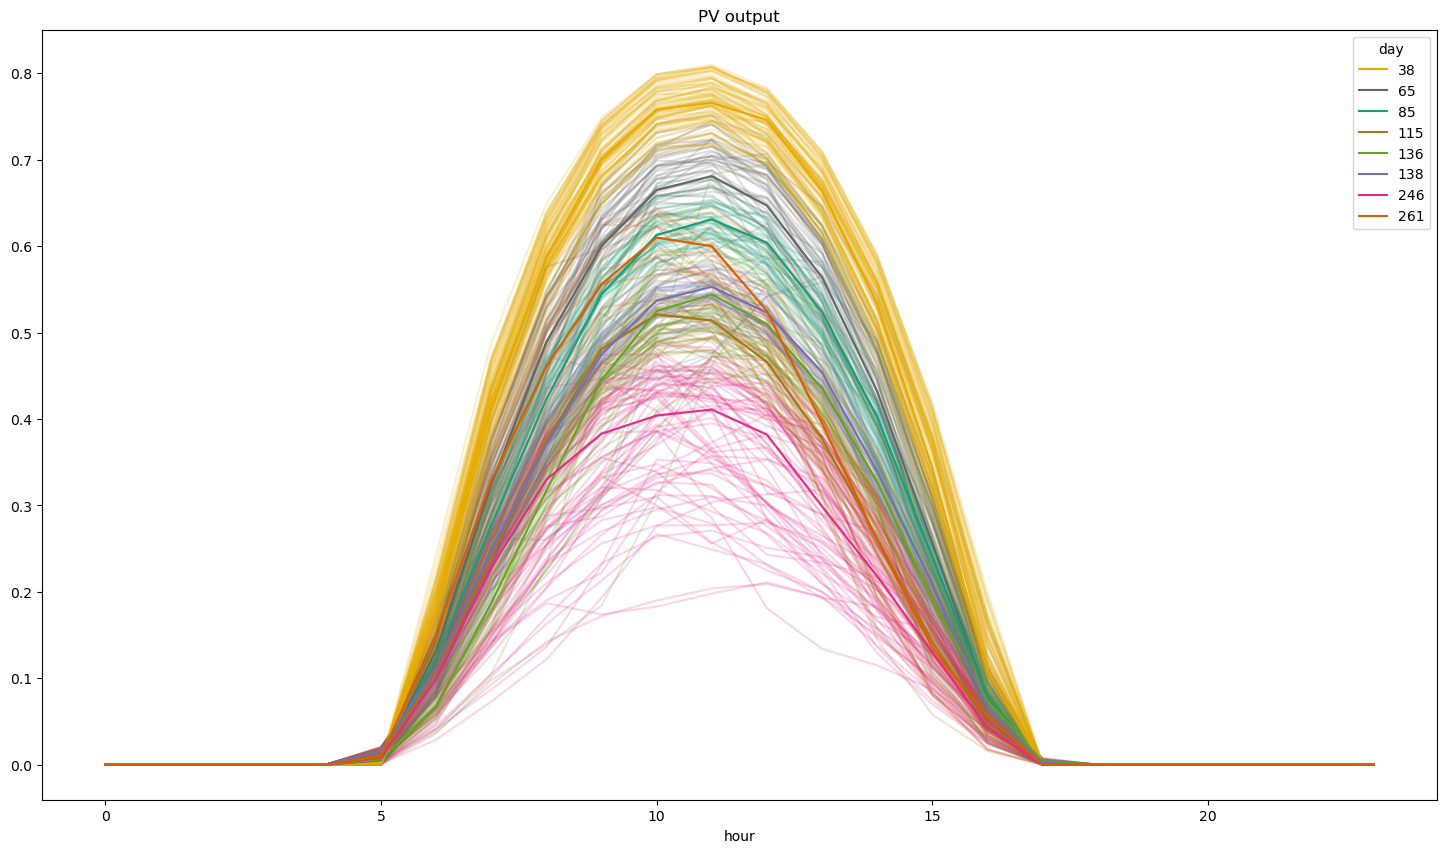

In [16]:
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
# A colormap with at least 8 different colors
cmap = get_cmap("Dark2")    # This colormap only has 8 colors, therefore it can only plot up to 8 clusters
colors = pv_clusters.apply(lambda v: cmap.colors[v])

fig, ax = plt.subplots(1, sharex=True, gridspec_kw=dict(hspace=0, wspace=0.01), figsize=(18, 10)) 
ax.set_title('PV output')  # set title

daily_pv.T.plot(ax=ax, legend=False, color=colors, alpha=0.2)  # plot all data
pv_scenarios.T.plot(ax=ax, color=[cmap.colors[i] for i in cluster_order])  # plot typical days
plt.savefig(f'cluster_Subtask1.png', bbox_inches='tight', dpi = 500)
plt.show()

### Addition of max. and min. solar irradiation

In [17]:
daily_pv

hour  0   1   2   3   4     5     6     7     8     9   ...    14    15    16  \
day                                                     ...                     
0      0   0   0   0   0     0 0.182 0.433 0.607 0.721  ...  0.54 0.354 0.112   
1      0   0   0   0   0 0.001 0.179 0.434 0.615 0.713  ... 0.528 0.332 0.091   
2      0   0   0   0   0     0 0.142  0.38 0.565 0.688  ... 0.487 0.288 0.069   
3      0   0   0   0   0     0 0.089 0.266 0.451 0.621  ... 0.511 0.303 0.063   
4      0   0   0   0   0     0 0.146 0.304 0.391 0.467  ... 0.487 0.312 0.079   
..    ..  ..  ..  ..  ..   ...   ...   ...   ...   ...  ...   ...   ...   ...   
360    0   0   0   0   0     0 0.129 0.375 0.567 0.704  ... 0.512 0.316 0.087   
361    0   0   0   0   0     0 0.184 0.437 0.615 0.736  ... 0.555 0.367 0.113   
362    0   0   0   0   0 0.001 0.201 0.455 0.627 0.745  ... 0.562 0.374 0.125   
363    0   0   0   0   0     0 0.156 0.398 0.576 0.702  ... 0.557 0.375 0.128   
364    0   0   0   0   0 0.001 0.213 0.462 0.629  0.74  ... 0.568 0.381 0.127   

hour  17  18  19  20  21  22  23  
day                               
0      0   0   0   0   0   0   0  
1      0   0   0   0   0   0   0  
2      0   0   0   0   0   0   0  
3      0   0   0   0   0   0   0  
4      0   0   0   0   0   0   0  
..    ..  ..  ..  ..  ..  ..  ..  
360    0   0   0   0   0   0   0  
361    0   0   0   0   0   0   0  
362    0   0   0   0   0   0   0  
363    0   0   0   0   0   0   0  
364    0   0   0   0   0   0   0  

[365 rows x 24 columns]

In [18]:
cluster_order

array([5, 7, 0, 6, 4, 2, 3, 1], dtype=int64)

In [19]:
n_days = len(daily_pv)
weights *= (n_days - 2) / n_days

# day with minimal and maximal pv irridiation
min_day = daily_pv.max(1).argmin()
max_day = daily_pv.values.argmax() // 24

# pv on minimal and maximal days
pv_daily_min = daily_pv.iloc[min_day] 
pv_daily_max = daily_pv.iloc[max_day]

# add minimal and maximal days with data to pv_scenarios
pv_scenarios.loc[min_day] = pv_daily_min
pv_scenarios.loc[max_day] = pv_daily_max

# add weight of minimal and maximal day to 1/365
weights[min_day] = 1 / n_days
weights[max_day] = 1 / n_days
weights.sort_index(inplace=True)
weights *= 365  # multiply again to have amount of days for each scenario
pv_scenarios.sort_index(inplace=True)  

### Demand data handling

In [20]:
demand_data = pd.read_csv('demand_data.csv',
                          usecols=[0, 1],
                          parse_dates=['time'],
                          date_parser=lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M'))
annual_demand = demand_data.groupby(pd.Grouper(freq='H', key='time')).mean().reset_index()
name = 'electricity_demand'
demand_data = annual_demand.rename(columns={"electricity": name})
demand_data['hour'] = demand_data.index % 24
demand_data['day'] = demand_data.index // 24  # new column with day number
demand_daily = demand_data[[name, 'day', 'hour']] \
    .set_index(['day', 'hour']).unstack()[name]
demand_cluster = demand_daily.loc[pv_scenarios.index]
demand_cluster

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11968\3902283683.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  demand_data = pd.read_csv('demand_data.csv',
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11968\3902283683.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  annual_demand = demand_data.groupby(pd.Grouper(freq='H', key='time')).mean().reset_index()


hour    0     1     2     3     4     5     6     7     8     9   ...    14  \
day                                                               ...         
38   321.1 323.1 317.3 316.2 311.2 309.6   316   320 324.5 329.4  ... 333.8   
65   344.6 343.4 338.2 338.6 343.4 340.6 339.4 341.3   338 336.9  ... 334.7   
85   320.6 326.2 327.3 327.7 326.2 324.7 323.3 320.3 315.9 316.7  ... 321.7   
115  308.3 308.2 307.3 306.5 309.4 354.8 433.4 559.3 599.1 588.7  ... 527.2   
136  312.7 316.9 314.3 314.5 313.5 312.9   326 331.8 331.2 329.2  ... 337.9   
138  315.9 317.4   313 308.4 313.2 345.2 409.2 490.9 545.3 546.6  ... 537.9   
226  290.5 290.3 286.4 290.3 289.5   290   290 290.2 291.4 291.6  ... 297.2   
246  293.6 296.1 290.6 290.1 291.5 290.7 290.3 290.8 287.1   291  ... 298.1   
261  284.4 285.2 283.9 280.8 284.6 285.3 288.1 283.3 284.7 287.9  ... 286.4   
356  350.3 344.2 336.6 336.4 331.8 332.6   373 450.1   540   599  ... 549.2   

hour    15    16    17    18    19    20    21    22    23  
day                                                         
38     336   337 340.9 339.6 329.4 322.6 319.2 318.9   318  
65   328.5 334.1 331.3   336 345.8 348.6 339.5 335.9 335.7  
85     312 309.8 308.7 306.8 308.7 314.8 317.6 314.7 314.2  
115  507.9   452 389.1 346.1 328.3 323.5 322.8 317.2 317.8  
136  335.8 340.7   339 325.1 316.5 311.4 309.3 310.2   309  
138  501.1 439.7 386.3 338.7 313.9   313 302.6 299.4 300.4  
226    294 300.7   302 300.4   302 301.4 297.8   298 295.9  
246  295.7 295.8 292.6 291.2 292.4 293.4 295.3 296.2 295.9  
261    287 285.1 284.1 285.2 294.1   287 288.2 287.5 287.4  
356  533.5 506.6 440.1 387.1 356.3 340.6 336.3 327.9 325.4  

[10 rows x 24 columns]

In [21]:
demand_cluster

hour    0     1     2     3     4     5     6     7     8     9   ...    14  \
day                                                               ...         
38   321.1 323.1 317.3 316.2 311.2 309.6   316   320 324.5 329.4  ... 333.8   
65   344.6 343.4 338.2 338.6 343.4 340.6 339.4 341.3   338 336.9  ... 334.7   
85   320.6 326.2 327.3 327.7 326.2 324.7 323.3 320.3 315.9 316.7  ... 321.7   
115  308.3 308.2 307.3 306.5 309.4 354.8 433.4 559.3 599.1 588.7  ... 527.2   
136  312.7 316.9 314.3 314.5 313.5 312.9   326 331.8 331.2 329.2  ... 337.9   
138  315.9 317.4   313 308.4 313.2 345.2 409.2 490.9 545.3 546.6  ... 537.9   
226  290.5 290.3 286.4 290.3 289.5   290   290 290.2 291.4 291.6  ... 297.2   
246  293.6 296.1 290.6 290.1 291.5 290.7 290.3 290.8 287.1   291  ... 298.1   
261  284.4 285.2 283.9 280.8 284.6 285.3 288.1 283.3 284.7 287.9  ... 286.4   
356  350.3 344.2 336.6 336.4 331.8 332.6   373 450.1   540   599  ... 549.2   

hour    15    16    17    18    19    20    21    22    23  
day                                                         
38     336   337 340.9 339.6 329.4 322.6 319.2 318.9   318  
65   328.5 334.1 331.3   336 345.8 348.6 339.5 335.9 335.7  
85     312 309.8 308.7 306.8 308.7 314.8 317.6 314.7 314.2  
115  507.9   452 389.1 346.1 328.3 323.5 322.8 317.2 317.8  
136  335.8 340.7   339 325.1 316.5 311.4 309.3 310.2   309  
138  501.1 439.7 386.3 338.7 313.9   313 302.6 299.4 300.4  
226    294 300.7   302 300.4   302 301.4 297.8   298 295.9  
246  295.7 295.8 292.6 291.2 292.4 293.4 295.3 296.2 295.9  
261    287 285.1 284.1 285.2 294.1   287 288.2 287.5 287.4  
356  533.5 506.6 440.1 387.1 356.3 340.6 336.3 327.9 325.4  

[10 rows x 24 columns]

### Objective functions and timesteps

In [22]:
operational_obj = grid['variable_costs']
dv_fixed_cost = ES.aggregate_component_expressions("fixed_costs")
dv_invest_cost = ES.aggregate_component_expressions('investment_costs')
investment_costs = dv_fixed_cost + dv_invest_cost
ts = (daily_pv.columns, 24)

### Problem creation

In [23]:
weights

day
38    83.54
65    42.76
85    37.79
115   43.76
136   30.83
138   39.78
226       1
246   66.63
261    17.9
356       1
dtype: float64

In [24]:
P = ES.create_problem(design_objective=investment_costs, 
                      operational_objective=operational_obj, 
                      timesteps=ts, 
                      scenarios=weights.to_dict(),
                      name='Subtask_1')
print(P)

Problem(name='Subtask_1')


In [25]:
print(f'Constraints of the problem: \n   {P.constraints} \n')
print(f'Operational objective: \n   {P.operational_objective} \n')
print(f'Design objective: \n   {P.design_objective} \n')

Constraints of the problem: 
   {'energy_system_Electricity_bus': Eq(demand_demand + batt_electricity_input - batt_electricity_output + grid_feeding - grid_use_grid - pv_el_out, 0), 'demand_IN': 0 <= demand_demand, 'batt_SOC_max': batt_SOC <= batt_size, 'batt_state_SOC': Eq(batt_SOCdot, 0.98*batt_electricity_input - 1.02040816326531*batt_electricity_output), 'pv_pv_el_out ≤ pv_power_factor*pv_size': pv_el_out <= pv_power_factor*pv_size} 

Operational objective: 
   grid_buy_price*grid_use_grid - grid_selling_price*grid_feeding 

Design objective: 
   113.021623504531*batt_size + 63.961044767334*pv_size 



In [26]:
P.data

### Setting the demand data in the problem formulation

In [27]:
data = pd.DataFrame()
data['demand'] = demand_cluster.values.reshape(-1)  # reshape lists all entries
data['pv_power_factor'] = pv_scenarios.values.reshape(-1)
P['demand_demand'] = data['demand']
P['pv_power_factor'] = data['pv_power_factor']
data['demand']

0     321.1
1     323.1
2     317.3
3     316.2
4     311.2
       ... 
235   356.3
236   340.6
237   336.3
238   327.9
239   325.4
Name: demand, Length: 240, dtype: float64

### Create a pyomo model from our created problem

In [28]:
from comando.interfaces.pyomo import to_pyomo
m = to_pyomo(P)

### Solving the problem with GLPK

In [29]:
options = dict(mipgap=0.01)
m.solve('glpk', options=options)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 438158.168317662
  Upper bound: 438158.168317662
  Number of objectives: 1
  Number of constraints: 1440
  Number of variables: 1683
  Number of nonzeros: 3482
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.10802412033081055
# ----------------------------------------------------------
#   Solution Information
# ------

{'Problem': [{'Name': 'unknown', 'Lower bound': 438158.168317662, 'Upper bound': 438158.168317662, 'Number of objectives': 1, 'Number of constraints': 1440, 'Number of variables': 1683, 'Number of nonzeros': 3482, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.10802412033081055}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Return the solution

In [30]:
dv = P.design
Total_cost = P.objective.value
ov = P.operation.T
ov["electricity_demand"] = data["demand"].values
ov["pv_power_factor"] = data["pv_power_factor"].values
ov["power_max"] = ov["pv_power_factor"] * dv.loc['pv_size']['value']
ov
print(ov)

name    batt_SOC  batt_SOCdot  batt_electricity_input  \
s   t                                                   
38  0          0            0                       0   
    1          0            0                       0   
    2          0            0                       0   
    3          0            0                       0   
    4          0            0                       0   
...          ...          ...                     ...   
356 19         0            0                       0   
    20         0            0                       0   
    21         0            0                       0   
    22         0            0                       0   
    23         0            0                       0   

name    batt_electricity_output  grid_feeding  grid_use_grid  pv_el_out  \
s   t                                                                     
38  0                         0             0          321.1          0   
    1                         0  

In [31]:
dv

value
name            
batt_size      0
pv_size    6,525

In [32]:
investment_costs

113.021623504531*batt_size + 63.961044767334*pv_size

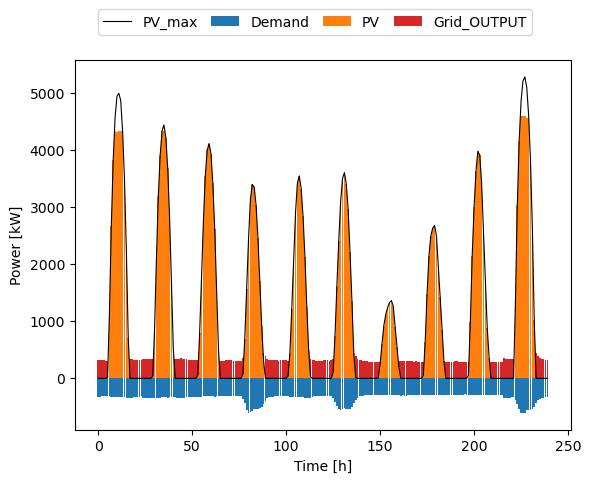

In [37]:
from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, sharex=True, gridspec_kw=dict(hspace=0, wspace=0.01))
hours = np.linspace(0, len(ov) - 1, len(ov))
ax.bar(hours, -ov['electricity_demand'].values, width=0.9, label='Demand', color='tab:blue')
ax.bar(hours, ov['pv_el_out'].values, width=0.9, label='PV', color='tab:orange')
ax.bar(hours, ov['grid_use_grid'].values, bottom=ov['pv_el_out'].values, width=0.9, label='Grid_OUTPUT', color='tab:red')
ax.plot(hours, ov['power_max'].values, label='PV_max', linewidth=0.8, color='black')
ax.set_ylabel('Power [kW]')
ax.set_xlabel('Time [h]')

fig.legend(loc='upper center', ncol=4, columnspacing=1, bbox_to_anchor=(0.5, 1.00))
plt.savefig(f'result1_Subtask1.png', bbox_inches='tight')
plt.show()

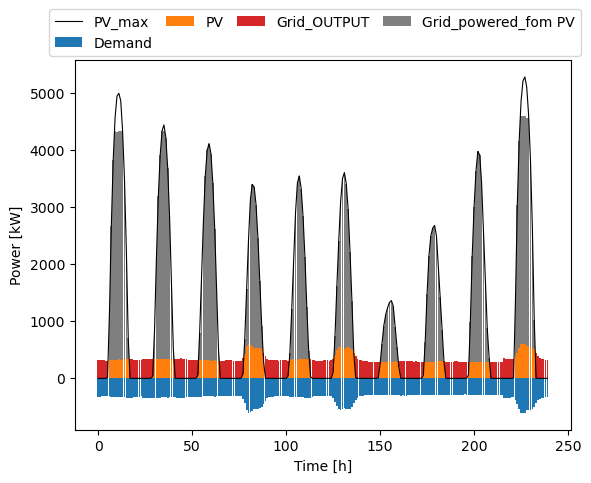

In [38]:
from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, sharex=True, gridspec_kw=dict(hspace=0, wspace=0.01))
hours = np.linspace(0, len(ov) - 1, len(ov))
ax.bar(hours, -ov['electricity_demand'].values, width=0.9, label='Demand', color='tab:blue')
ax.bar(hours, ov['pv_el_out'].values, width=0.9, label='PV', color='tab:orange')
ax.bar(hours, ov['grid_use_grid'].values, bottom=ov['pv_el_out'].values, width=0.9, label='Grid_OUTPUT', color='tab:red')
ax.bar(hours, -ov['grid_feeding'].values, bottom=ov['pv_el_out'].values, width=0.9, label='Grid_powered_fom PV', color='tab:grey')
#ax.bar(hours, ov['batt_electricity_output'].values, bottom=ov['pv_el_out'].values, width=0.9, label='BATT_OUT', color='tab:green')
ax.plot(hours, ov['power_max'].values, label='PV_max', linewidth=0.8, color='black')
ax.set_ylabel('Power [kW]')
ax.set_xlabel('Time [h]')

fig.legend(loc='upper center', ncol=4, columnspacing=1, bbox_to_anchor=(0.5, 1.00))
plt.savefig(f'result2_Subtask1.png', bbox_inches='tight', dpi = 300)
plt.show()


In [39]:
ov.head(40)

name    batt_SOC  batt_SOCdot  batt_electricity_input  \
s  t                                                    
38 0           0            0                       0   
   1           0            0                       0   
   2           0            0                       0   
   3           0            0                       0   
   4           0            0                       0   
   5           0            0               8.684e-14   
   6           0            0                       0   
   7           0            0                       0   
   8           0            0                       0   
   9           0    4.547e-13                       0   
   10          0    4.547e-13                       0   
   11          0            0                       0   
   12  4.268e-13    4.547e-13                4.64e-13   
   13 -8.288e-14   -4.547e-13                       0   
   14 -2.994e-14            0                       0   
   15          0   -4.547e-13                       0   
   16          0            0                       0   
   17          0            0                       0   
   18          0            0                       0   
   19          0            0                       0   
   20          0            0                       0   
   21          0            0                       0   
   22          0            0                       0   
   23          0            0                       0   
65 0           0            0                       0   
   1           0            0                       0   
   2           0            0                       0   
   3           0            0                       0   
   4           0            0                       0   
   5           0            0               1.755e-14   
   6           0            0                       0   
   7           0            0                       0   
   8           0            0                       0   
   9           0   -4.547e-13                       0   
   10 -2.283e-14            0              -2.329e-14   
   11  -4.62e-14    4.547e-13              -2.385e-14   
   12          0            0                       0   
   13          0            0                       0   
   14          0            0                       0   
   15          0   -4.547e-13                       0   

name   batt_electricity_output  grid_feeding  grid_use_grid  pv_el_out  \
s  t                                                                     
38 0                         0             0          321.1          0   
   1                         0             0          323.1          0   
   2                         0             0          317.3          0   
   3                         0             0          316.2          0   
   4                         0             0          311.2          0   
   5                         0             0            290      19.57   
   6                         0         832.4              0      1,148   
   7                         0         2,355              0      2,675   
   8                         0         3,505              0      3,830   
   9                         0         4,000              0      4,329   
   10                        0         4,000              0      4,324   
   11                        0         4,000              0      4,331   
   12                        0         4,000              0      4,330   
   13                8.698e-13         4,000              0      4,332   
   14               -5.188e-14         3,150              0      3,484   
   15                        0         1,902              0      2,238   
   16                        0         367.7              0      704.7   
   17                        0             0          340.9          0   
   18                        0             0          339.6          0   
   19                        0             0       

In [40]:
Total_cost 

438158.168317662